In [1]:
## Load Packages
using Omega
using StatsBase
using Random
using Plots
using Distributions


Internal error: encountered unexpected error in runtime:
rec_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\stackwalk.c:94
record_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:246
jl_throw at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:577
jl_bounds_error_ints at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\rtutils.c:187
getindex at .\array.jl:731
jfptr_getindex_2272.clone_1 at C:\Users\Devon Kohler\AppData\Local\Julia-1.0.5\lib\julia\sys.dll (unknown line)
jl_apply_generic at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\gf.c:2162
replace_code_newstyle! at .\compiler/ssair\legacy.jl:86

## Main Functions

In [2]:

function get_hazards(rng, n)
    """
    Compute the hazard function given the current states. "spawn_prey" represents 
    the event of a prey being born, "prey2pred" represents a predator consuming 
    a new prey and consequently spawning a new predator, "pred_dies" represents 
    the death of a predator. The function probabilistically selects one of these 
    based on their weights.

    args:
        rng(): julia base random number generator, do not need to explicitly pass
        n(int): An index to the current step in prey and pred lists. Used to pull
                most recent values for calculations
    """

    ecology = Dict("prey" => prey_list[n](rng), "pred" => pred_list[n](rng))

    hazards = Dict(
        "spawn_prey" => theta(rng)["spawn_prey"] * ecology["prey"],
        "prey2pred" => theta(rng)["prey2pred"] * ecology["prey"] * ecology["pred"],
        "pred_dies" => theta(rng)["pred_dies"] * ecology["pred"]
        )

    vals = collect(values(hazards))
    sum_vals = sum(vals)
    prob_vals = vals/sum_vals
    categorical(rng, prob_vals)
end

function one_simulation_prey(rng, n, transitions)

    """
    Simulates one step of gillespie for prey. Takes generated hazards
    adds it to prey and outputs the new value.
    
    args:
        rng(): julia base random number generator, do not need to explicitly pass
        n(int): An index to the current step in prey and pred lists. Used to pull
                most recent values for calculations
        transitions: Matrix that determines how much prey/pred should change based
                    on selected hazard
    """

    #t = t_list[n](rng)
    hazard_result = hazards_list[n](rng)
    prey_val = prey_list[n](rng)
    labels = ["spawn_prey", "pred_dies","prey2pred"]
    transition = transitions[labels[hazard_result]]
    new_prey = prey_val + transition[1]

    # Enforce only positive integers
    max(1, new_prey)

end

function one_simulation_pred(rng, n, transitions)

    """
    Simulates one step of gillespie for pred. Takes generated hazards
    adds it to pred and outputs the new value.
    
    args:
        rng(): julia base random number generator, do not need to explicitly pass
        n(int): An index to the current step in prey and pred lists. Used to pull
                most recent values for calculations
        transitions: Matrix that determines how much prey/pred should change based
                    on selected hazard
    """

    #t = t_list[n](rng)
    hazard_result = hazards_list[n](rng)
    pred_val = pred_list[n](rng)
    labels = ["spawn_prey", "pred_dies","prey2pred"]
    transition = transitions[labels[hazard_result]]
    new_pred = pred_val + transition[2]

    # Enforce only positive integers
    max(1, new_pred)

end


one_simulation_pred (generic function with 1 method)

Redefine functions to remove randomness from rates

In [3]:
function get_hazards(rng, n)

    ecology = Dict("prey" => prey_list[n](rng), "pred" => pred_list[n](rng))

    hazards = Dict(
        "spawn_prey" => theta["spawn_prey"] * ecology["prey"],
        "prey2pred" => theta["prey2pred"] * ecology["prey"] * ecology["pred"],
        "pred_dies" => theta["pred_dies"] * ecology["pred"]
        )

    vals = collect(values(hazards))
    sum_vals = sum(vals)
    prob_vals = vals/sum_vals
    categorical(rng, prob_vals)
end

get_hazards (generic function with 1 method)

In [4]:
## Initialize paramters
Pre = [[1, 0], [1, 1], [0, 1]]
Post = [[2, 0], [0, 2], [0, 0]]
transition_mat = Post - Pre
transitions = Dict("spawn_prey" => transition_mat[1,],
                    "prey2pred" => transition_mat[2,],
                    "pred_dies" => transition_mat[3,])


Dict{String,Array{Int64,1}} with 3 entries:
  "spawn_prey" => [1, 0]
  "pred_dies"  => [0, -1]
  "prey2pred"  => [-1, 1]

# Abduction-action-prediction

"Given a certain number of predators and prey at time t+k, how many predators and prey would there have been if predators stopped eating from time t to t+j,  where j < k?"

## Small Cycle Ground Truth Counterfactual

In [36]:
# Random variables for small cycles
prey_init = normal(5., .001)
pred_init = normal(5., .001)

# Random variables for rates
spawn_prey = 1.5
prey2pred = 1.0
pred_dies = 3.0

theta =  Dict("spawn_prey" => spawn_prey,
         "prey2pred" => prey2pred,
         "pred_dies" => pred_dies)

Dict{String,Float64} with 3 entries:
  "spawn_prey" => 1.5
  "pred_dies"  => 3.0
  "prey2pred"  => 1.0

In [37]:
## Initialize lists and add starting rand vars
hazards_list = Any[]
prey_list = Any[]
pred_list = Any[]
push!(prey_list, prey_init)
push!(pred_list, pred_init)

## How many time periods to cycle over
N = 100

## Create a prey/pred/hazard for each time period
for f in 2:N
    last = f - 1
    hazards_temp = ciid(get_hazards, last) # individual step
    prey_temp = ciid(one_simulation_prey, last, transitions) # individual step
    pred_temp = ciid(one_simulation_pred, last, transitions) # individual step
    push!(hazards_list, hazards_temp)
    push!(prey_list, prey_temp)
    push!(pred_list, pred_temp)
end

## Convert lists to single tuple
random_var_tuple = (Tuple(x for x in hazards_list)...,
                Tuple(x for x in prey_list)...,
                Tuple(x for x in pred_list)...)
print()

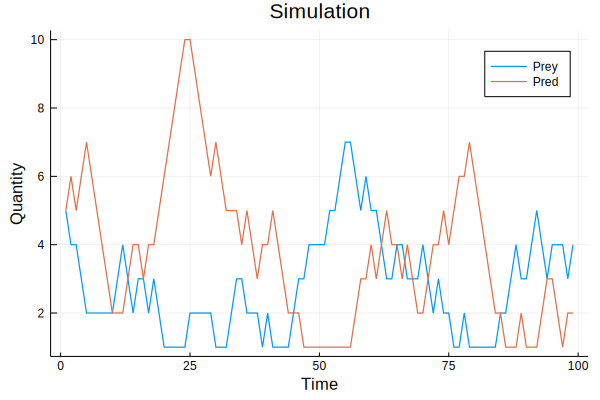

In [38]:
## Sample
Random.seed!(1234) ## Must initialize seed each time if run line by line
samples = rand(random_var_tuple, 1, alg = RejectionSample)

# extract run results and plot
prey_vals = []
pred_vals = []
for x in 1:(N-1)
    push!(prey_vals,samples[1][N+x-1])
    push!(pred_vals,samples[1][(N*2)+x-1])
end

plot(hcat(prey_vals,pred_vals),
        title = "Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["Prey" "Pred"],
        lw = 1.25)


Apply intervention from 75 to 85, prey spawns.

In [39]:
ground_truth_hazards = [x for x in samples[1][1:75]]
print()

In [40]:
ground_truth_prey = [x for x in samples[1][100:175]]
print()

In [41]:
ground_truth_pred = [x for x in samples[1][200:275]]
print()

In [42]:
for x in 1:10
    push!(ground_truth_hazards, 1)
    push!(ground_truth_prey, ground_truth_prey[length(ground_truth_prey)] + 1)
    push!(ground_truth_pred, ground_truth_pred[length(ground_truth_pred)])
end

In [43]:
## Initialize lists and add starting rand vars
hazards_list = Any[]
prey_list = Any[]
pred_list = Any[]

push!(prey_list, normal(ground_truth_prey[length(ground_truth_prey)], .0001))
push!(pred_list, normal(ground_truth_pred[length(ground_truth_pred)], .0001))

## How many time periods to cycle over
N = 15

## Create a prey/pred/hazard for each time period
for f in 2:N
    last = f - 1
    hazards_temp = ciid(get_hazards, last) # individual step
    
    ## Condition on prey in this example
    prey_temp = ciid(one_simulation_prey, last, transitions)
    pred_temp = ciid(one_simulation_pred, last, transitions)

    push!(hazards_list, hazards_temp)
    push!(prey_list, prey_temp)
    push!(pred_list, pred_temp)
end

random_var_tuple = (Tuple(x for x in hazards_list)...,
                Tuple(x for x in prey_list)...,
                Tuple(x for x in pred_list)...)
print()


In [44]:
Random.seed!(1234) ## Must initialize seed each time if run line by line
int_samples = rand(random_var_tuple, 1, alg = RejectionSample)

1-element Array{Tuple{Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64},1}:
 (3, 3, 3, 3, 2, 2, 2, 3, 3, 1, 1, 3, 3, 2, 11.000022971823713, 10.000022971823713, 9.000022971823713, 8.000022971823713, 7.000022971823713, 7.000022971823713, 7.000022971823713, 7.000022971823713, 6.000022971823713, 5.000022971823713, 6.000022971823713, 7.000022971823713, 6.000022971823713, 5.000022971823713, 5.000022971823713, 5.000072833927318, 6.000072833927318, 7.000072833927318, 8.000072833927318, 9.000072833927318, 8.000072833927318, 7.000072833927318, 6.000072833927318, 7.000072833927318, 8.000072833927318, 8.000072833927318, 8.000072833927318, 9.000072833927318, 10.000072833927318, 9.000072833927318)

In [45]:
# extract run results and plot
for x in 2:(N-1)
    push!(ground_truth_prey,int_samples[1][N+x])
    push!(ground_truth_pred,int_samples[1][(N*2)+x])
end


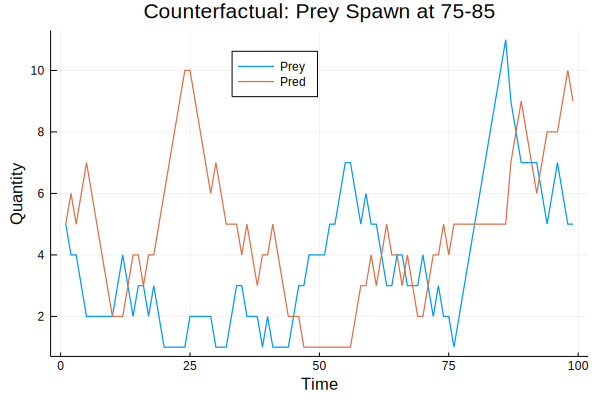

In [46]:
plot(hcat(ground_truth_prey,ground_truth_pred),
        title = "Counterfactual: Prey Spawn at 75-85",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["Prey" "Pred"],
        lw = 1.25,
        legend = :top)

In [47]:
prey_vals = convert(Array{Float64,1}, prey_vals)
pred_vals = convert(Array{Float64,1}, pred_vals)
print()

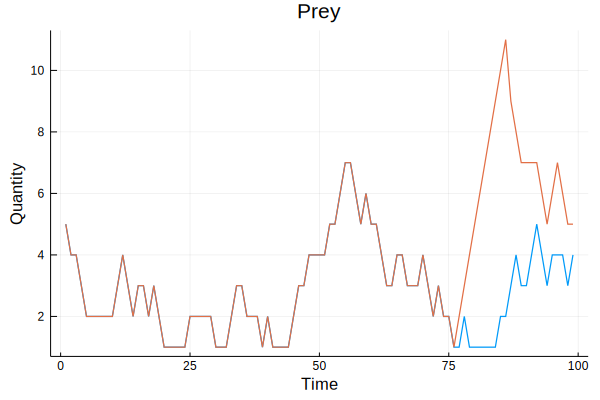

In [48]:
plot1 = plot(hcat(prey_vals, ground_truth_prey),
        title = "Prey",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["Ground Truth" "Intervention"],
        lw = 1.25,
        legend = false)

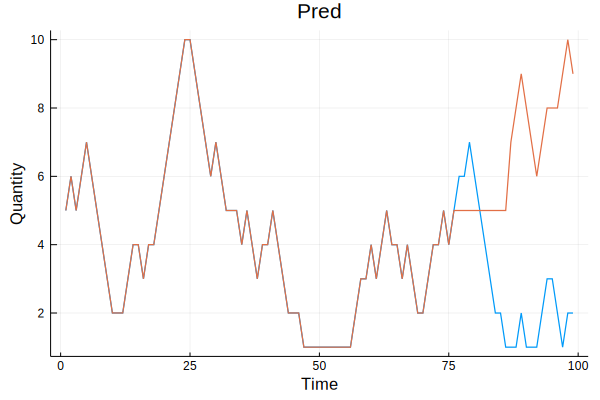

In [49]:
plot2 = plot(hcat(pred_vals, ground_truth_pred),
        title = "Pred",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["Ground Truth" "Intervention"],
        lw = 1.25,
        legend = false)

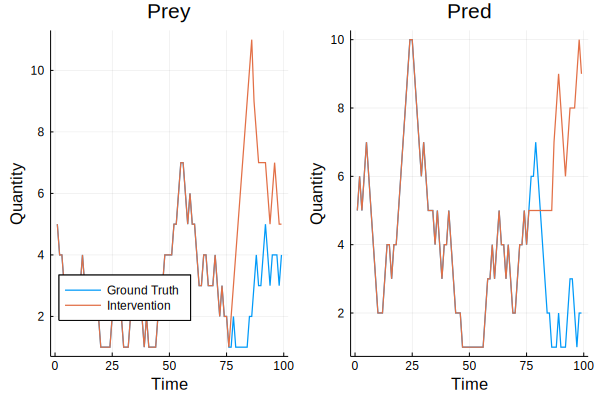

In [50]:
plot(plot1, plot2,layout = (1, 2), legend = :bottom)

## Large Cycle Groundtruth Counterfactuals

In [5]:
# Random variables for small cycles
prey_init = normal(60., .001)
pred_init = normal(100., .001)

# Random variables for rates
spawn_prey = .9
prey2pred = .004
pred_dies = .4

theta =  Dict("spawn_prey" => spawn_prey,
         "prey2pred" => prey2pred,
         "pred_dies" => pred_dies)

Dict{String,Float64} with 3 entries:
  "spawn_prey" => 0.9
  "pred_dies"  => 0.4
  "prey2pred"  => 0.004

In [6]:
## Initialize lists and add starting rand vars
hazards_list = Any[]
prey_list = Any[]
pred_list = Any[]
push!(prey_list, prey_init)
push!(pred_list, pred_init)

## How many time periods to cycle over
N = 1000

## Create a prey/pred/hazard for each time period
for f in 2:N
    last = f - 1
    hazards_temp = ciid(get_hazards, last) # individual step
    prey_temp = ciid(one_simulation_prey, last, transitions) # individual step
    pred_temp = ciid(one_simulation_pred, last, transitions) # individual step
    push!(hazards_list, hazards_temp)
    push!(prey_list, prey_temp)
    push!(pred_list, pred_temp)
end

## Convert lists to single tuple
random_var_tuple = (Tuple(x for x in hazards_list)...,
                Tuple(x for x in prey_list)...,
                Tuple(x for x in pred_list)...)
print()

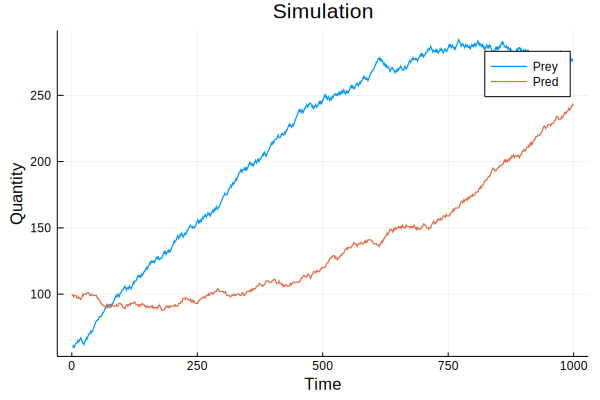

In [7]:
## Sample
Random.seed!(1234) ## Must initialize seed each time if run line by line
samples = rand(random_var_tuple, 1, alg = RejectionSample)

# extract run results and plot
prey_vals = []
pred_vals = []
for x in 1:(N-1)
    push!(prey_vals,samples[1][N+x-1])
    push!(pred_vals,samples[1][(N*2)+x-1])
end

plot(hcat(prey_vals,pred_vals),
        title = "Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["Prey" "Pred"],
        lw = 1.25)


Apply intervention from 75 to 85, prey spawns.

In [8]:
ground_truth_hazards = [x for x in samples[1][1:750]]
ground_truth_prey = [x for x in samples[1][1000:1750]]
ground_truth_pred = [x for x in samples[1][2000:2750]]
print()

In [9]:
for x in 1:100
    push!(ground_truth_hazards, 1)
    push!(ground_truth_prey, ground_truth_prey[length(ground_truth_prey)] + 1)
    push!(ground_truth_pred, ground_truth_pred[length(ground_truth_pred)])
end

In [10]:
## Initialize lists and add starting rand vars
hazards_list = Any[]
prey_list = Any[]
pred_list = Any[]

push!(prey_list, normal(ground_truth_prey[length(ground_truth_prey)], .0001))
push!(pred_list, normal(ground_truth_pred[length(ground_truth_pred)], .0001))

## How many time periods to cycle over
N = 150

## Create a prey/pred/hazard for each time period
for f in 2:N
    last = f - 1
    hazards_temp = ciid(get_hazards, last) # individual step
    
    ## Condition on prey in this example
    prey_temp = ciid(one_simulation_prey, last, transitions)
    pred_temp = ciid(one_simulation_pred, last, transitions)

    push!(hazards_list, hazards_temp)
    push!(prey_list, prey_temp)
    push!(pred_list, pred_temp)
end

random_var_tuple = (Tuple(x for x in hazards_list)...,
                Tuple(x for x in prey_list)...,
                Tuple(x for x in pred_list)...)
print()


In [11]:
Random.seed!(1234) ## Must initialize seed each time if run line by line
int_samples = rand(random_var_tuple, 1, alg = RejectionSample)
print()

In [12]:
# extract run results and plot
for x in 2:(N-1)
    push!(ground_truth_prey,int_samples[1][N+x])
    push!(ground_truth_pred,int_samples[1][(N*2)+x])
end


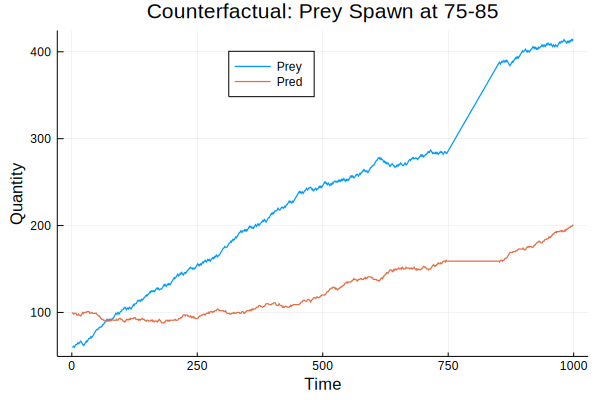

In [13]:
plot(hcat(ground_truth_prey,ground_truth_pred),
        title = "Counterfactual: Prey Spawn at 75-85",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["Prey" "Pred"],
        lw = 1.25,
        legend = :top)

In [14]:
prey_vals = convert(Array{Float64,1}, prey_vals)
pred_vals = convert(Array{Float64,1}, pred_vals)
print()

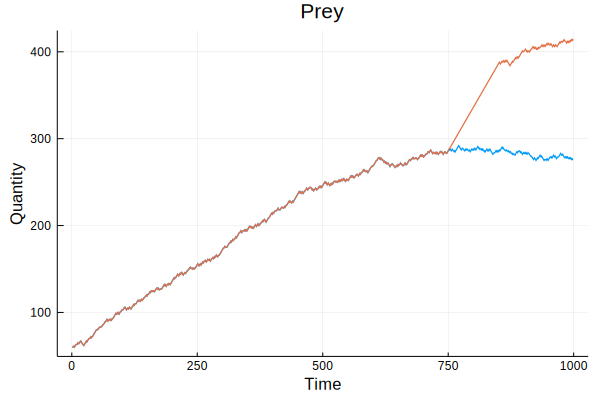

In [15]:
prey_vals = convert(Array{Float64,1}, prey_vals)
pred_vals = convert(Array{Float64,1}, pred_vals)

plot1 = plot(hcat(prey_vals, ground_truth_prey),
        title = "Prey",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["Ground Truth" "Intervention"],
        lw = 1.25,
        legend = false)

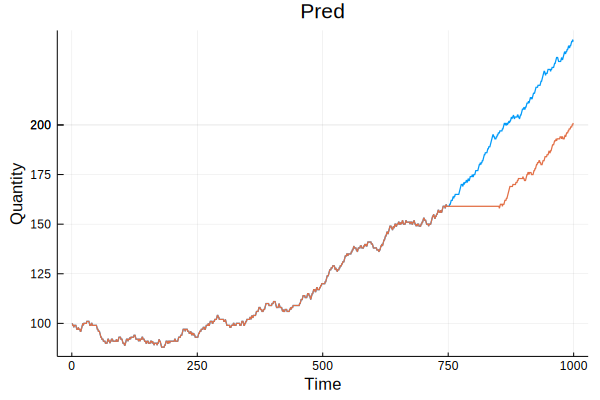

In [16]:
plot2 = plot(hcat(pred_vals, ground_truth_pred),
        title = "Pred",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["Ground Truth" "Intervention"],
        lw = 1.25,
        legend = false)

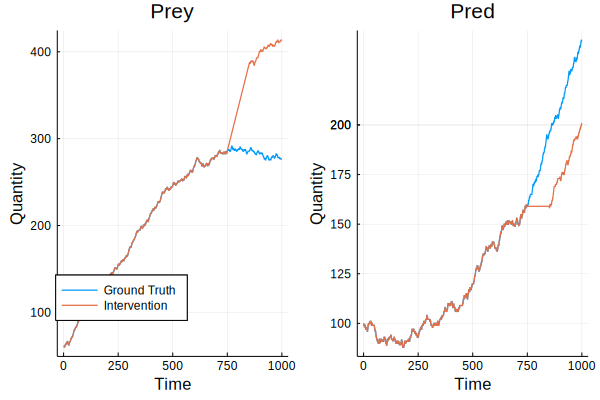

In [17]:
plot(plot1, plot2,layout = (1, 2), legend = :bottom)

In [18]:
ground_truth_prey[999] - prey_vals[999]
ground_truth_pred[999] - pred_vals[999]

137.00002297182374

In [19]:
ground_truth_pred[999] - pred_vals[999]

-40.999927166072695

## Use Abuduction to Infer Noise

$$P(N_{prey}, N_{pred} | \text{Prey}_{T1000} = 275, \text{Pred}_{T1000} = 245)$$

In [44]:
## Initialize lists and add starting rand vars
prey_init = uniform(10:150)
pred_init = uniform(10:150)
hazards_list = Any[]
prey_list = Any[]
pred_list = Any[]

push!(prey_list, prey_init)
push!(pred_list, pred_init)

## How many time periods to cycle over
N = 1000

## Indices to condition on
condition_index = 100

## Create a prey/pred/hazard for each time period
for f in 2:N
    last = f - 1
    hazards_temp = ciid(get_hazards, last) # individual step
    
    ## Condition on prey in this example
    prey_temp = ciid(one_simulation_prey, last, transitions)
    pred_temp = ciid(one_simulation_pred, last, transitions)

    push!(hazards_list, hazards_temp)
    push!(prey_list, prey_temp)
    push!(pred_list, pred_temp)
end

random_var_tuple = (Tuple(x for x in hazards_list)...,
                Tuple(x for x in prey_list)...,
                Tuple(x for x in pred_list)...)
print()


In [ ]:
## Sample
#Random.seed!(1234) ## Must initialize seed each time if run line by line
sample_list = Any[]
for x in 1:250000
    samples = rand(random_var_tuple, 1, alg = RejectionSample)
    if samples[1][1999] <= 277.5 && samples[1][1999] >= 272.5 &&
            samples[1][2999] >= 241.5 && samples[1][2999] <= 245.5
        push!(sample_list, samples)
    end
end 

In [ ]:
length(sample_list)

In [481]:
# extract run results and plot 
prey_vals1 = []
prey_vals2 = []
for x in 0:(N-1)
    push!(prey_vals1,sample_list[1][1][N+x])
    push!(prey_vals2,sample_list[2][1][N+x])
end
prey_matrix = hcat(prey_vals1, prey_vals2)

for x in 3:50
    temp = []
    for y in 0:(N-1)
        push!(temp,sample_list[x][1][N+y])
    end
    prey_matrix = hcat(prey_matrix, temp)
end


In [469]:
push!(prey_vals, 275.)

1000-element Array{Float64,1}:
  60.00022971823713
  60.00022971823713
  61.00022971823713
  61.00022971823713
  60.00022971823713
  61.00022971823713
  62.00022971823713
  63.00022971823713
  63.00022971823713
  63.00022971823713
  64.00022971823714
  65.00022971823714
  64.00022971823714
   ⋮               
 278.00022971823716
 277.00022971823716
 277.00022971823716
 278.00022971823716
 277.00022971823716
 278.00022971823716
 277.00022971823716
 276.00022971823716
 277.00022971823716
 276.00022971823716
 276.00022971823716
 275.0             

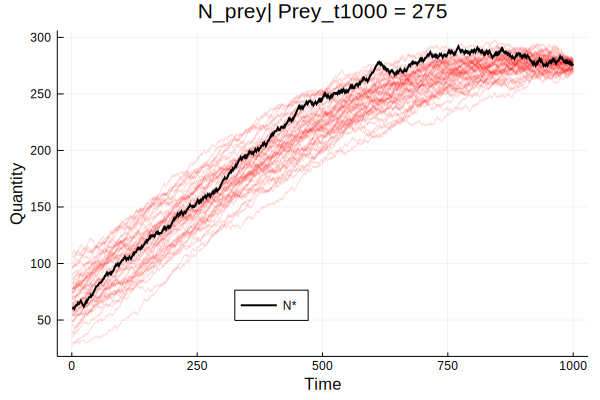

In [486]:
prey_matrix = convert.(Float64, prey_matrix)
plot(1:1000, prey_matrix,
        title = "N_prey| Prey_t1000 = 275",
        xlabel = "Time",
        ylabel = "Quantity",
        linealpha = .15,
        label = false,
        color = "red")
plot!(prey_vals, linewidth = 2.0, color = "black", legend = :bottom, label = "N*")

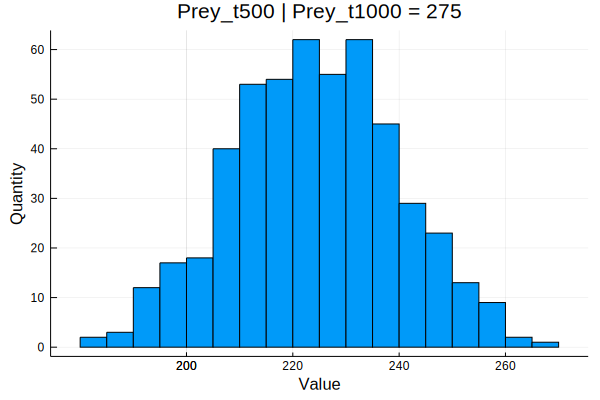

In [479]:
histogram([round(x) for x in prey_matrix[500,:]],
        title = "Prey_t500 | Prey_t1000 = 275",
        xlabel = "Value",
        ylabel = "Quantity",
        legend = false)

## Sample from infered traces and run counterfactuals

In [45]:
function infer_trace_counterfactuals()
    function get_hazards_int(rng, n)

        ecology = Dict("prey" => prey_list_int[n](rng), "pred" => pred_list_int[n](rng))

        hazards = Dict(
            "spawn_prey" => theta["spawn_prey"] * ecology["prey"],
            "prey2pred" => theta["prey2pred"] * ecology["prey"] * ecology["pred"],
            "pred_dies" => theta["pred_dies"] * ecology["pred"]
            )

        vals = collect(values(hazards))
        sum_vals = sum(vals)
        prob_vals = vals/sum_vals
        categorical(rng, prob_vals)
    end

    function one_simulation_prey_int(rng, n, transitions)

        #t = t_list[n](rng)
        hazard_result = hazards_list_int[n](rng)
        prey_val = prey_list_int[n](rng)
        labels = ["spawn_prey", "pred_dies","prey2pred"]
        transition = transitions[labels[hazard_result]]
        new_prey = prey_val + transition[1]

        # Enforce only positive integers
        max(1, new_prey)

    end

    function one_simulation_pred_int(rng, n, transitions)

        #t = t_list[n](rng)
        hazard_result = hazards_list_int[n](rng)
        pred_val = pred_list_int[n](rng)
        labels = ["spawn_prey", "pred_dies","prey2pred"]
        transition = transitions[labels[hazard_result]]
        new_pred = pred_val + transition[2]

        # Enforce only positive integers
        max(1, new_pred)

    end
    
    trace_samples = Any[]
    trace_int_samples = Any[]
    check = 0
    
    while check <= 100
        Random.seed!(rand(1:1000000000000))
        samples = rand(random_var_tuple, 1, alg = RejectionSample)
        if samples[1][1999] <= 277.5 && samples[1][1999] >= 272.5 &&
                samples[1][2999] >= 241.5 && samples[1][2999] <= 245.5
            
            push!(trace_samples, samples)
            
            ground_truth_hazards = [x for x in samples[1][1:750]]
            ground_truth_prey = [x for x in samples[1][1000:1750]]
            ground_truth_pred = [x for x in samples[1][2000:2750]]
            
            for x in 1:100
                push!(ground_truth_hazards, 1)
                push!(ground_truth_prey, ground_truth_prey[length(ground_truth_prey)] + 1)
                push!(ground_truth_pred, ground_truth_pred[length(ground_truth_pred)])
            end
            
            ## Initialize model for counterfactual
            global hazards_list_int = Any[]
            global prey_list_int = Any[]
            global pred_list_int = Any[]

            push!(prey_list_int, normal(ground_truth_prey[length(ground_truth_prey)], .0001))
            push!(pred_list_int, normal(ground_truth_pred[length(ground_truth_pred)], .0001))

            ## How many time periods to cycle over
            N = 150

            ## Create a prey/pred/hazard for each time period
            for f in 2:N
                last = f - 1
                hazards_temp = ciid(get_hazards_int, last) # individual step

                ## Condition on prey in this example
                prey_temp = ciid(one_simulation_prey_int, last, transitions)
                pred_temp = ciid(one_simulation_pred_int, last, transitions)

                push!(hazards_list_int, hazards_temp)
                push!(prey_list_int, prey_temp)
                push!(pred_list_int, pred_temp)
            end

            random_var_tuple_int = (Tuple(x for x in hazards_list_int)...,
                            Tuple(x for x in prey_list_int)...,
                            Tuple(x for x in pred_list_int)...)
            
            int_samples = rand(random_var_tuple_int, 1, alg = RejectionSample)
            push!(trace_int_samples, int_samples)
            check = check + 1
            print(check)
        end
    end
    
    return (trace_samples, trace_int_samples)
end

infer_trace_counterfactuals (generic function with 1 method)

In [46]:
test = infer_trace_counterfactuals()
print()

123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101

In [47]:
prey_diff = Any[]
pred_diff = Any[]

for idx in 1:length(test[1])
    
    prey_temp = test[2][idx][1][299] - test[1][idx][1][1999]
    pred_temp = test[2][idx][1][449] - test[1][idx][1][2999]
    
    push!(prey_diff, prey_temp)
    push!(pred_diff, pred_temp)
end

In [48]:
prey_matrix = []
prey_matrix_int = []

pred_matrix = []
pred_matrix_int = []

for idx in 1:length(test[1])
    
    push!(prey_matrix, [x for x in test[1][idx][1][1000:1999]])
    push!(prey_matrix_int, vcat([x for x in test[1][idx][1][1000:1749]], 
                            [test[1][idx][1][1749] + n for n in 1:100], 
                            [x for x in test[2][idx][1][150:299]]))
    
    push!(pred_matrix, [x for x in test[1][idx][1][2000:2999]])
    push!(pred_matrix_int, vcat([x for x in test[1][idx][1][2000:2749]], 
                            [test[1][idx][1][2749] for n in 1:100], 
                            [x for x in test[2][idx][1][300:449]]))
    
end

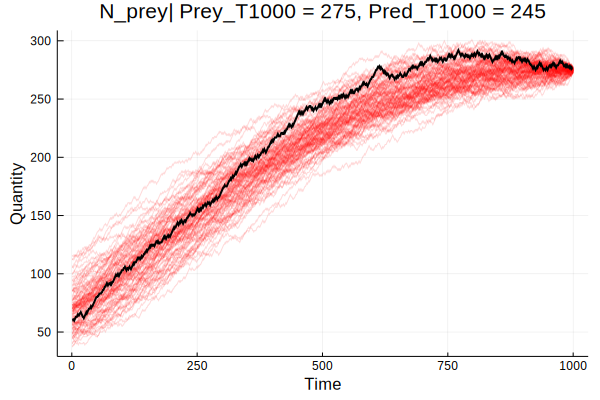

In [51]:
#prey_matrix = convert.(Float64, prey_matrix)
plot(title = "N_prey|  Prey_T1000 = 275, Pred_T1000 = 245",
        xlabel = "Time",
        ylabel = "Quantity",
        label = false,
        legend = false
        )
for idx in 1:length(prey_matrix)
    plot!(prey_matrix[idx, :], color = "red", linealpha = .15, legend = false)
end
plot!(prey_vals, linewidth = 2.0, color = "black", legend = false, label = "N*")

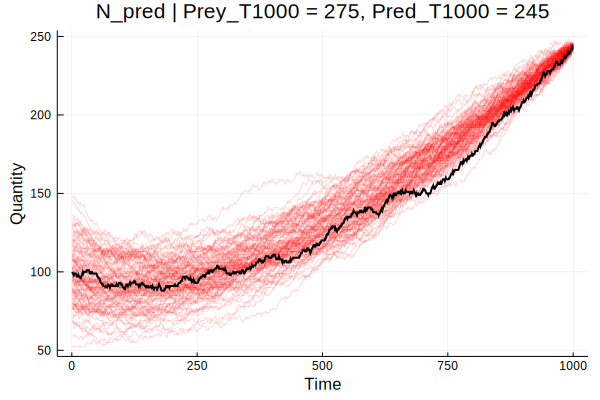

In [52]:
#prey_matrix = convert.(Float64, prey_matrix)
plot(title = "N_pred |  Prey_T1000 = 275, Pred_T1000 = 245",
        xlabel = "Time",
        ylabel = "Quantity",
        label = false,
        legend = false
        )
for idx in 1:length(pred_matrix)
    plot!(pred_matrix[idx, :], color = "red", linealpha = .15, legend = false)
end
plot!(pred_vals, linewidth = 2.0, color = "black", legend = false, label = "N*")

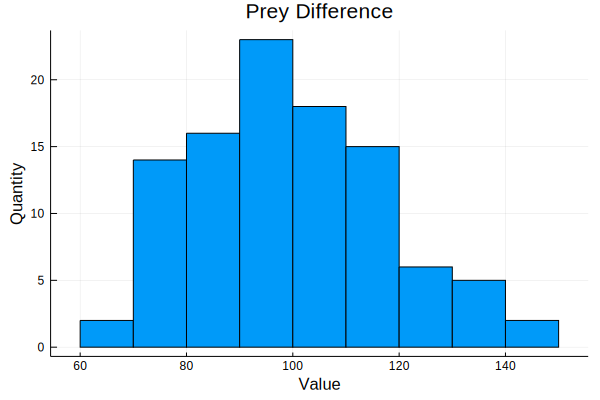

In [53]:
histogram(prey_diff,
        title = "Prey Difference",
        xlabel = "Value",
        ylabel = "Quantity",
        legend = false)

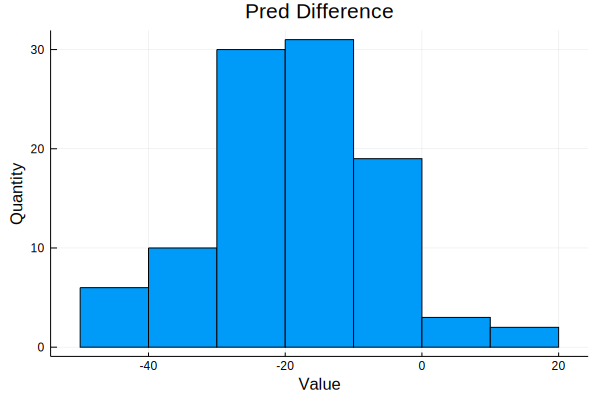

In [54]:
histogram(pred_diff,
        title = "Pred Difference",
        xlabel = "Value",
        ylabel = "Quantity",
        legend = false)

In [153]:
histogram([round(x) for x in prey_matrix[:,30]],
        title = "Prey_t500 | Prey_t1000 = 275",
        xlabel = "Value",
        ylabel = "Quantity",
        legend = false)

BoundsError: BoundsError: attempt to access 31-element Array{Any,1} at index [Base.Slice(Base.OneTo(31)), 30]

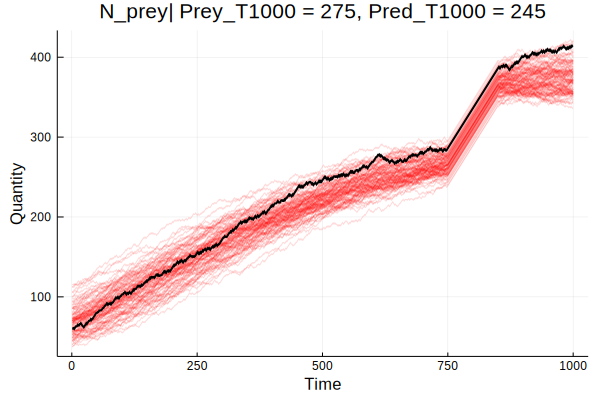

In [55]:
#prey_matrix = convert.(Float64, prey_matrix)
plot(title = "N_prey|  Prey_T1000 = 275, Pred_T1000 = 245",
        xlabel = "Time",
        ylabel = "Quantity",
        label = false,
        legend = false
        )
for idx in 1:length(prey_matrix)
    plot!(prey_matrix_int[idx, :], color = "red", linealpha = .15, legend = false)
end
plot!(ground_truth_prey, linewidth = 2.0, color = "black", legend = false, label = "N*")

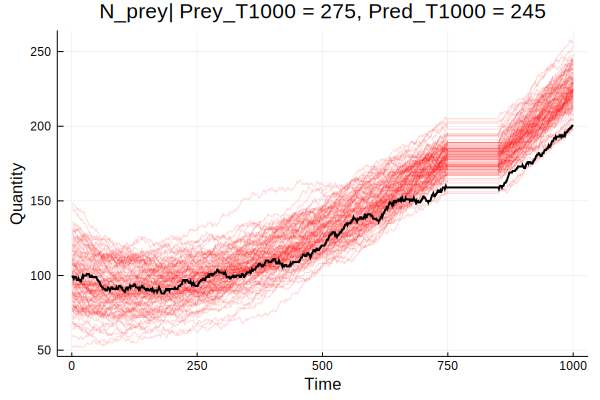

In [56]:
#prey_matrix = convert.(Float64, prey_matrix)
plot(title = "N_prey|  Prey_T1000 = 275, Pred_T1000 = 245",
        xlabel = "Time",
        ylabel = "Quantity",
        label = false,
        legend = false
        )
for idx in 1:length(prey_matrix)
    plot!(pred_matrix_int[idx, :], color = "red", linealpha = .15, legend = false)
end
plot!(ground_truth_pred, linewidth = 2.0, color = "black", legend = false, label = "N*")